In [39]:
import numpy as np
import logomaker
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import defaultdict

In [5]:
# Load the text file
with open("motifs.txt", "r") as f:
    raw_data = f.read()

# Regex to split motifs
motif_blocks = re.findall(r'(MOTIF\s+\d+.*?)(?=MOTIF\s+\d+|\Z)', raw_data, re.DOTALL)

motifs = []

# Map index to base
base_order = ['A', 'C', 'G', 'T']

for block in motif_blocks:
    # Extract lines with matrix values only
    lines = block.strip().splitlines()
    matrix_lines = [line for line in lines if re.match(r'^\s*\d*\.?\d+\s+', line)]

    motif = defaultdict(list)

    for line in matrix_lines:
        probs = list(map(float, line.strip().split()))
        for i, base in enumerate(base_order):
            motif[base].append(probs[i])
    
    motifs.append(dict(motif))

In [6]:
def calculate_information_content(motif):
    ic = np.log2(4) + (motif * np.log2(motif)).sum(axis=1)
    ic = ic.fillna(0)  # Handle NaNs resulting from log2(0)
    return ic

In [9]:
df = pd.read_csv("sites.tsv", sep="\t")

In [10]:
position_counts = defaultdict(lambda: defaultdict(int))
total_counts = defaultdict(int)

for _, row in df.iterrows():
    # Skip rows with missing start/end
    if pd.isna(row['site_Start']) or pd.isna(row['site_End']):
        continue

    motif = row['motif_ALT_ID']
    try:
        start = int(row['site_Start'])
        end = int(row['site_End'])
    except ValueError:
        continue  # skip if conversion fails

    # Only count positions within the 1–30 range
    for pos in range(start, end + 1):
        if 1 <= pos <= 30:
            position_counts[motif][pos] += 1

    total_counts[motif] += 1

In [11]:
num_missing = df['site_Start'].isna().sum() + df['site_End'].isna().sum()
print(f"Skipped {num_missing} rows due to missing site_Start or site_End.")

Skipped 52 rows due to missing site_Start or site_End.


In [12]:
# Create list of all unique motifs
motifs_ids = list(position_counts.keys())

# Build final table
data = []

for motif in motifs_ids:
    row = {'motif_ALT_ID': motif}
    total = total_counts[motif]
    row['total'] = total

    # Fill in positions 1–30
    for pos in range(1, 31):
        row[f'pos{pos}'] = position_counts[motif].get(pos, 0)
    
    data.append(row)

# Convert to DataFrame
result_df = pd.DataFrame(data)

In [20]:
def numeric_sort_index(df):
    # Extract the number from strings like "STREME-11"
    nums = df.index.to_series().str.extract(r'(\d+)$').astype(int)[0]
    return df.iloc[nums.argsort()]

In [21]:
# Build df_start used for Column 4
df_start = (
    df.dropna(subset=['site_Start'])
      .assign(site_Start=lambda x: x['site_Start'].astype(int))
      .query('1 <= site_Start <= 30')
      .groupby(['motif_ALT_ID', 'site_Start'])
      .size()
      .unstack(fill_value=0)
)

# Ensure all positions exist
for pos in range(1, 31):
    if pos not in df_start.columns:
        df_start[pos] = 0
df_start = df_start[sorted(df_start.columns)]

# Sort index numerically
df_start = numeric_sort_index(df_start)


In [22]:
# Build df_end used for Column 5
df_end = (
    df.dropna(subset=['site_End'])
      .assign(site_End=lambda x: x['site_End'].astype(int))
      .query('1 <= site_End <= 30')
      .groupby(['motif_ALT_ID', 'site_End'])
      .size()
      .unstack(fill_value=0)
)

for pos in range(1, 31):
    if pos not in df_end.columns:
        df_end[pos] = 0
df_end = df_end[sorted(df_end.columns)]
df_end = numeric_sort_index(df_end)

In [24]:
# Fractions of hits at each position used for Column 3
result_fraction_df = result_df.set_index('motif_ALT_ID').copy()
for pos in range(1, 31):
    result_fraction_df[f'pos{pos}'] = (
        result_fraction_df[f'pos{pos}'] / result_fraction_df['total'].replace(0, np.nan)
    ).fillna(0)

# Sort same as df_start/df_end
result_fraction_df = numeric_sort_index(result_fraction_df)

In [26]:
#Fractions of start and end used for Column 4 and 5

df_start_frac = df_start.div(df_start.sum(axis=1), axis=0).fillna(0)
df_end_frac = df_end.div(df_end.sum(axis=1), axis=0).fillna(0)

In [31]:
plot_data = []

# Loop through motifs in the already-sorted result_df
for mid in result_df['motif_ALT_ID']:
    plot_data.append({
        'id': mid,
        'logo_matrix': pd.DataFrame(motifs[result_df['motif_ALT_ID'].tolist().index(mid)]),
        'pos_fraction': result_fraction_df.loc[mid, [f'pos{p}' for p in range(1, 31)]].values,
        'start_fraction': df_start_frac.loc[mid].values,
        'end_fraction': df_end_frac.loc[mid].values
    })

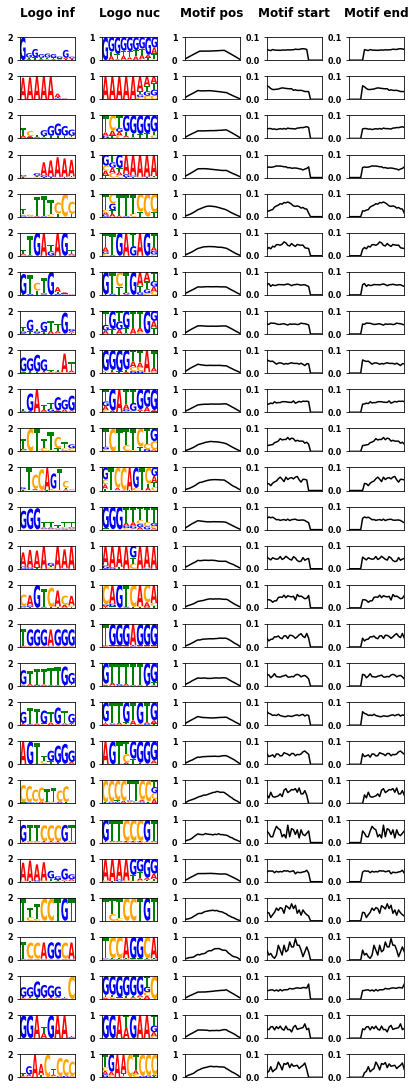

In [43]:
# Number of motifs
num_motifs = len(plot_data)

# Create subplots
fig, axes = plt.subplots(num_motifs, 5, figsize=(5 * 35 / 25.4, 18 / 25.4 * num_motifs))
plt.subplots_adjust(wspace=0.5, hspace=0.7)

# Define the titles for each column
col_titles = [
    "Logo inf",
    "Logo nuc",
    "Motif pos",
    "Motif start",
    "Motif end"
]

# Position titles above the top row's axes
for col_idx, title in enumerate(col_titles):
    ax = axes[0][col_idx]
    ax.set_title(title, fontsize=12, fontweight='bold', pad=20)

# Loop over motifs
for i, motif_entry in enumerate(plot_data):
    row_axes = axes[i]  # 5 axes in a row
    motif_name = motif_entry['id']

    # Extract precomputed data
    df_logo = motif_entry['logo_matrix']
    pos_fraction = motif_entry['pos_fraction']
    start_fraction = motif_entry['start_fraction']
    end_fraction = motif_entry['end_fraction']

    # Calculate information content
    ic = calculate_information_content(df_logo)
    df_ic = df_logo.mul(ic, axis=0)

    color_scheme = {
        'A': 'red',
        'C': 'orange',
        'G': 'blue',
        'T': 'green'
    }

    # Column 1: Information content logo
    logomaker.Logo(df_ic, ax=row_axes[0], color_scheme=color_scheme)
    row_axes[0].set_xticks([])
    row_axes[0].set_ylim(0, 2)

    # Column 2: Nucleotide content logo
    logomaker.Logo(df_logo, ax=row_axes[1], color_scheme=color_scheme)
    row_axes[1].set_xticks([])
    row_axes[1].set_ylim(0, 1)

    # Column 3: Position hits
    row_axes[2].plot(range(1, 31), pos_fraction, color='black')
    row_axes[2].set_ylim(0, 1)
    row_axes[2].set_xlim(1, 30)
    row_axes[2].set_xticks([])

    # Column 4: Start positions
    row_axes[3].plot(range(1, 31), start_fraction, color='black')
    row_axes[3].set_ylim(0, 0.1)
    row_axes[3].set_xlim(1, 30)
    row_axes[3].set_xticks([])

    # Column 5: End positions
    row_axes[4].plot(range(1, 31), end_fraction, color='black')
    row_axes[4].set_ylim(0, 0.1)
    row_axes[4].set_xlim(1, 30)
    row_axes[4].set_xticks([])

    # Y-axis styling
    for ax in row_axes:
        ax.tick_params(axis='y', labelsize=8)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(8)
            tick.set_fontweight('bold')

# Save & show
plt.savefig("combined_motifs_all_in_one.pdf", bbox_inches='tight')
plt.show()